# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
norm = transforms.Normalize(mean=[0.5], std=[0.5])
transform = transforms.Compose([transforms.ToTensor(), norm])

# Create training set and define training dataloader
train_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=True,
    transform=transform,
    download=True
)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=128,
    shuffle=True,
    drop_last=True
)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=False,
    transform=transform,
    download=True
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=128,
    shuffle=True,
    drop_last=True
)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I used:
1. `transforms.ToTensor()`: This transform converts the input image from the PIL to PyTorch tensor, which is the expected input format for neural networks in PyTorch.

2. `transforms.Normalize(mean=[0.5], std=[0.5])`: This transform normalizes the tensor values of the image with the mean and standard deviation of the MNIST dataset.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

6


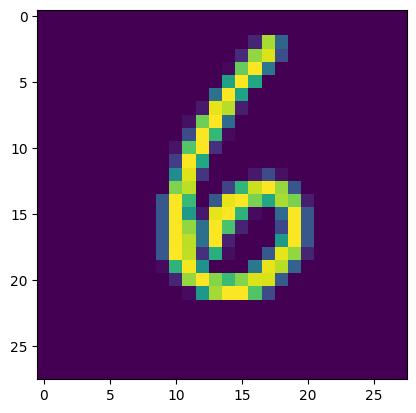

7


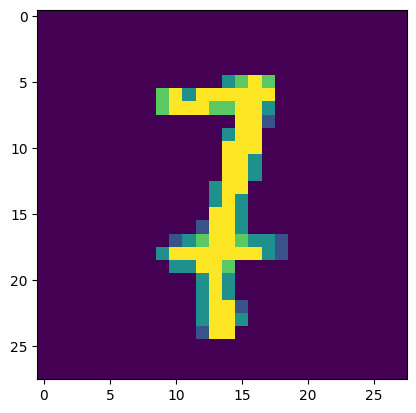

5


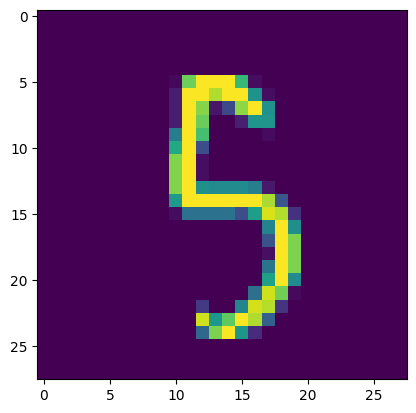

3


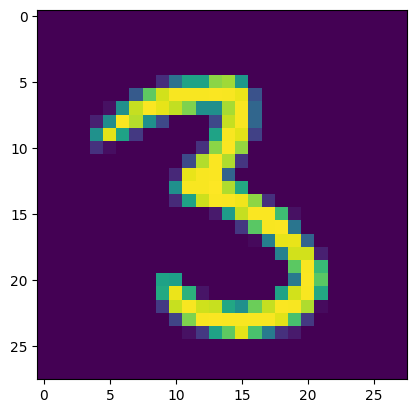

6


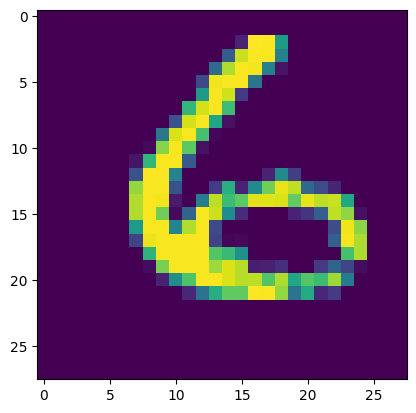

In [6]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # flatten
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [15]:
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [16]:
learning_rate = 0.001
momentum = 0.9

optimizer = optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=momentum,
    weight_decay=0.0005
    )

criterion = nn.NLLLoss().to(device)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [17]:
epochs = 35
steps = 0
train_loss = 0
print_every = 5

train_loss_history = list()
valid_loss_history = list()

for epoch in range(epochs):
    for images, labels in train_loader:
        steps += 1

        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        train_loss_history.append(train_loss/len(train_loader))

        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    images.requires_grad = True

                    logits = model(images)
                    batch_loss = criterion(logits, labels)
                    valid_loss += batch_loss.item()

                    valid_loss_history.append(valid_loss/len(test_loader))

                    # Calculate accuracy
                    probs = torch.exp(logits)
                    _, top_class = probs.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Training Loss: {train_loss/print_every:.3f}.. "
                  f"Validation Loss: {valid_loss/len(test_loader):.3f}.. "
                  f"Accuracy: {accuracy/len(test_loader):.3f}")
            train_loss = 0
            model.train()

Epoch 1/35.. Training Loss: 2.308.. Validation Loss: 2.305.. Accuracy: 0.101
Epoch 1/35.. Training Loss: 2.307.. Validation Loss: 2.304.. Accuracy: 0.106
Epoch 1/35.. Training Loss: 2.304.. Validation Loss: 2.303.. Accuracy: 0.113
Epoch 1/35.. Training Loss: 2.306.. Validation Loss: 2.302.. Accuracy: 0.121
Epoch 1/35.. Training Loss: 2.302.. Validation Loss: 2.301.. Accuracy: 0.128
Epoch 1/35.. Training Loss: 2.309.. Validation Loss: 2.300.. Accuracy: 0.135
Epoch 1/35.. Training Loss: 2.306.. Validation Loss: 2.299.. Accuracy: 0.139
Epoch 1/35.. Training Loss: 2.301.. Validation Loss: 2.298.. Accuracy: 0.143
Epoch 1/35.. Training Loss: 2.305.. Validation Loss: 2.297.. Accuracy: 0.147
Epoch 1/35.. Training Loss: 2.309.. Validation Loss: 2.295.. Accuracy: 0.151
Epoch 1/35.. Training Loss: 2.295.. Validation Loss: 2.294.. Accuracy: 0.159
Epoch 1/35.. Training Loss: 2.299.. Validation Loss: 2.293.. Accuracy: 0.167
Epoch 1/35.. Training Loss: 2.302.. Validation Loss: 2.292.. Accuracy: 0.174

KeyboardInterrupt: ignored

In [ ]:
## ps I stopped the training when I noticed that the accuracy stabalized ^

Plot the training loss (and validation loss/accuracy, if recorded).

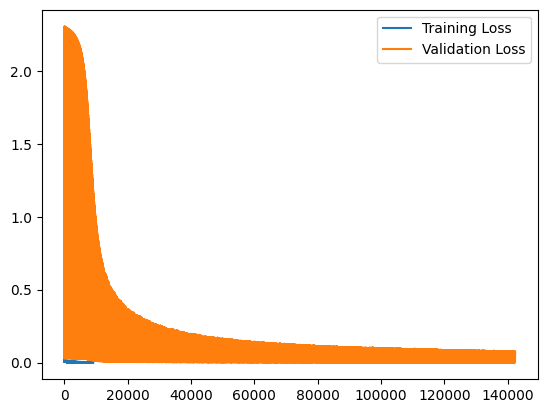

In [18]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(valid_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 90%, great work, but see if you can push a bit further!
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [19]:
test_loss = 0
accuracy = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True

        logits = model(images)
        batch_loss = criterion(logits, labels)

        test_loss += batch_loss.item()

        # Calculate accuracy
        probs = torch.exp(logits)
        _, top_class = probs.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test accuracy: {accuracy/len(test_loader):.3f}")

Test accuracy: 0.975


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [21]:
learning_rate = 0.01
momentum = 0.5

optimizer = optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=momentum,
    weight_decay=0.0005
    )

In [22]:
epochs = 20
steps = 0
train_loss = 0
print_every = 5

train_loss_history = list()
valid_loss_history = list()

for epoch in range(epochs):
    for images, labels in train_loader:
        steps += 1

        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        train_loss_history.append(train_loss/len(train_loader))

        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    images.requires_grad = True

                    logits = model(images)
                    batch_loss = criterion(logits, labels)
                    valid_loss += batch_loss.item()

                    valid_loss_history.append(valid_loss/len(test_loader))

                    # Calculate accuracy
                    probs = torch.exp(logits)
                    _, top_class = probs.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Training Loss: {train_loss/print_every:.3f}.. "
                  f"Validation Loss: {valid_loss/len(test_loader):.3f}.. "
                  f"Accuracy: {accuracy/len(test_loader):.3f}")
            train_loss = 0
            model.train()

Epoch 1/20.. Training Loss: 0.070.. Validation Loss: 0.075.. Accuracy: 0.976
Epoch 1/20.. Training Loss: 0.185.. Validation Loss: 0.076.. Accuracy: 0.975
Epoch 1/20.. Training Loss: 0.207.. Validation Loss: 0.077.. Accuracy: 0.974
Epoch 1/20.. Training Loss: 0.217.. Validation Loss: 0.076.. Accuracy: 0.974
Epoch 1/20.. Training Loss: 0.226.. Validation Loss: 0.078.. Accuracy: 0.974
Epoch 1/20.. Training Loss: 0.225.. Validation Loss: 0.078.. Accuracy: 0.974
Epoch 1/20.. Training Loss: 0.256.. Validation Loss: 0.077.. Accuracy: 0.974
Epoch 1/20.. Training Loss: 0.245.. Validation Loss: 0.078.. Accuracy: 0.975
Epoch 1/20.. Training Loss: 0.223.. Validation Loss: 0.077.. Accuracy: 0.975
Epoch 1/20.. Training Loss: 0.255.. Validation Loss: 0.077.. Accuracy: 0.975
Epoch 1/20.. Training Loss: 0.215.. Validation Loss: 0.076.. Accuracy: 0.975
Epoch 1/20.. Training Loss: 0.195.. Validation Loss: 0.076.. Accuracy: 0.975
Epoch 1/20.. Training Loss: 0.165.. Validation Loss: 0.077.. Accuracy: 0.975

KeyboardInterrupt: ignored

In [ ]:
# I also stopped here because it stabalized

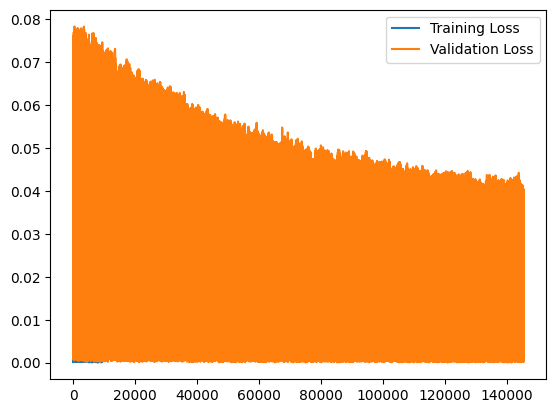

In [24]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(valid_loss_history, label="Validation Loss")
plt.legend()
plt.show()

In [23]:
test_loss = 0
accuracy = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True

        logits = model(images)
        batch_loss = criterion(logits, labels)

        test_loss += batch_loss.item()

        # Calculate accuracy
        probs = torch.exp(logits)
        _, top_class = probs.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test accuracy: {accuracy/len(test_loader):.3f}")

Test accuracy: 0.987


## Saving your model
Using `torch.save`, save your model for future loading.

In [29]:
# Save the checkpoint
model.class_to_idx = train_data.class_to_idx
torch.save({
            "epochs": epochs,
            "optimizer": optimizer.state_dict(),
            "state_dict": model.state_dict(),
            "class_to_idx": model.class_to_idx
            }, "checkpoint.pth")